M=0.9975558530913629
Tyablikov
SSWT


Callen
 54.705262 seconds (414.90 M allocations: 16.652 GiB, 5.98% gc time, 0.28% compilation time)


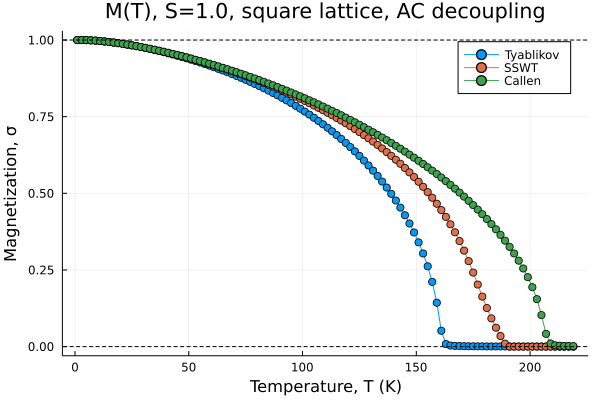

In [45]:
using Polynomials
using Printf
using Plots
using LinearAlgebra
#using LoopVectorization
const μB=5.7883818060e-5 # eV/T
const kB=8.617333262e-5
const nkx=50; const nky=nkx
const J = [10*0.001, 0*0.001]; const D=J[1]/10
const S=1.0
const Niter=200
#const z=[4,4]
const δ=1e-4
const latt="square"
const SIA="AC" #HP0, HP1, 


function S_solver(S, ϕ::Float64)
# This solver finds expectation values <(Sz)> and <(Sz)^2> for a given S and ϕ within the Tyablikov approximation. 
# ϕ is a function of the magnon spectrum, which also depends on <Sz> and (in some cases) <(Sz)^2>, i.e., for a given magnon spectrum,
# <Sz> is to be obtained iteratively. 
# Theory can be found, e.g., in the book "Quantum Theory of Magnetism" by W. Nolting and A. Ramakanth (Springer-Verlag, Berlin, Heidelberg 2009).
    if !isinteger(S*2)
        error("ERROR! S is neither integer nor half-integer")
    end
    if (S>9)
        error("ERROR! S>9, are you sure? Polynomial coefficients will contain very big numbers. 
        Numerical errors are unavoidable. (<(Sz)^2>=(<Sz>)^2 is a good approximation for large S.")
    end
if S==1/2
        Sz = S / (1 + 2ϕ)
        SzSz = S^2
        return Sz, SzSz
    elseif S==1
        Sz = S*(1 + 2ϕ) / (1 + 3ϕ + 3ϕ^2)
        SzSz = 2*S^2 - (Sz)*(1+2ϕ)
        return Sz, SzSz
end    
Nproj = round(Int,2S+1)
Pdim = Nproj + 1
aux=zeros(0)
for mz in -S:1:S
    push!(aux,mz)                         # Eq.(7.485)
end
p0 = fromroots(aux)
Matr = vcat(transpose(collect(p0)))                    # matrix constructed from the polynomial coefficients
for n = 0 : 1 : round(Int,2*S-1)         
    m = n + 1
    coefs_lhs = zeros(Pdim)               # Eq.(7.489)
    coefs_lhs[m] = S*(S+1)  
    coefs_lhs[m+1] = -1
    coefs_lhs[m+2] = -1
lhs = Polynomial(coefs_lhs)
rhs = 2*fromroots([0])*fromroots(ones(n)) + ( fromroots(ones(n)) - fromroots(zeros(n)) ) * ( S*(S+1)*Polynomial([1]) - Polynomial([0,1]) - Polynomial([0,0,1]) )
    coefs_rhs = ϕ * vcat(collect(rhs),zeros(Nproj-m))
    Matr = vcat(Matr,transpose(coefs_lhs-coefs_rhs))    # append polynomial coefficients to the matrix for each n
end
    A0 = -Matr[:,1]                       # x*A = A0, x[1] = <Sz>, x[2] = <(Sz)^2>, etc.
    A = Matr[:,2:Pdim]
    x = inv(A)*A0
    Sz = x[1] ; SzSz = x[2]
    return Sz, SzSz
end

function n0(β,ε)
    n0 = (exp(β*ε) - 1)^(-1)
end

function Sz(S,ϕ)
    if !isinteger(S*2)
        println("WARNING! S is neither integer nor half-integer")
    end
    if S==1/2
        num = S
        den = 1 + 2ϕ
    elseif S==1
        num = S*(1 + 2ϕ)
        den = 1 + 3ϕ + 3ϕ^2
    else
    num = (S - ϕ)*(1 + ϕ)^(2S+1) + (1 + S + ϕ)*ϕ^(2S+1)
    den = (1 + ϕ)^(2S+1) - ϕ^(2S+1)
    end
    return num/den
end


function γk(x,y)
    gamma = Float64[]
    if latt == "square"
        γ1 = 2*( cos(2π*x) + cos(2π*y) )  
        γ2 = 4*( cos(2π*x)*cos(2π*y) )
    end
    if latt == "triangular"
        γ1 = 2*(cos(2π*x) + 2*cos(2π*x/2)*cos(2π*√3y/2) )
        γ2 = 2*(cos(2π*√3y) + 2*cos(2π*3x/2)*cos(2π*√3y/2) )
    end
 #   if latt == "honeycomb"
 #       gamma = Complex{Float64}[]
 #       γ1 = 1 + 2*cos(2π*x/2)*exp(im*2π√3ky/2)
 #       γ2 = 2*(cos(2π*x) + 2*cos(2π*x/2)*cos(2π*√3y/2) )
 #   end
    push!(gamma,γ1)
    push!(gamma,γ2)
    return gamma
end


function magnetization(T,method,Bz)
    if (method != "Tyablikov") && 
       (method != "Callen") &&
       (method != "SSWT")
        error("Unknown method")
    end
#    @printf("%s \n",method)
    β=1/kB/T
    σ = S
    σ_prev = 0.0
    a = 1
    q = zeros(size(J,1))
    final = false
global dispersion = zeros(nkx,nkx)
    P0 = 0.0
    for iter = 1:Niter
        P0i = 0.0
        Q0 = 0.0
        qi = zeros(size(J,1))
 #       (1 - 2*P0/S) < 0 && (Δ=0) #avoids negative Ωk. 
  #     (1 - 2*P0/S) < 0 && (P0 = S/2) #avoids negative Ωk. single-line 'if'
        #
        if   SIA=="AC"
       #      SzSz = 2 - σ*(1 + 2*P0)          # this works for S=1 only!
             SzSz = S_solver(1, P0)[2]
             Φ = 2*σ*(1 - (S*(S+1) - SzSz) / (2*S^2))
             ΩSIA = D*Φ
        elseif SIA=="HP0"
             ΩSIA = (2S-1)*D
        elseif SIA=="HP2"
             ΩSIA = (2S-1)*D*(1-2*P0/S)
        elseif SIA=="SSWT"
             ΩSIA = (2S-1)*D*(σ/S)^2
        else
             error("Unknown method for SIA decoupling")
        end
        #
        #
        if     method=="Tyablikov"
            ν = zeros(size(J,1))
        elseif method=="SSWT"
 #           if SIA!=="SSWT"&&(method=="SSWT")
 #               println("WARNING! SSWT method only works with its own SIA decoupling.")
 #           end
            ν = q
            ΩSIA = (2S-1)*D*(σ/S)^2
        elseif method=="Callen"
            a = (σ/S)^1 # or (σ/S)^3
            ν = q.*(σ/S)*a
        else
            error("Unknown method for magnon dispersion")
        end
        #
        J0 = γk(0,0).*J
        for ikx = 1 : nkx, iky = 1 : nky
            kx = ikx - nkx/2 ; ky = iky - nky/2
            if kx==0&&ky==00 
                continue
            end
            γ = γk(kx/nkx,ky/nky)
            Jk = γ.*J
            Ωk = (σ .+ ν)⋅(J0 - Jk) + ΩSIA     + 2*μB*Bz  #
            P0i += n0(β,Ωk)  / (nkx*nky) 
            qi += n0(β,Ωk).*γ./γk(0,0)  / (nkx*nky) 
    #        if (final) 
    #            dispersion[ikx,iky] = Ωk
    #        end
        end
        #
    P0 = P0i
#    Q0 = 1.0 + 2*P0
    q = qi
    method == "SSWT" ? σ = S - P0i : σ = Sz(S,P0)  #σ = S / Q0 for S=1/2
    #
        if (abs(σ-σ_prev)<δ) && (iter>3)
            (!final) ? final=true : break
        elseif ((σ<=0)||(σ>S))#||(P0>S*0.9)) 
            σ=0
            break 
        end 
#     @printf("%5i %12.10f %8.6f %6i \n", iter, σ,  ΩSIA, T)
    σ_prev = σ
    end
    return σ
end

function main()

  #  println(γk(0,0))
    println("M=",magnetization(10,"Tyablikov",0.0))
    
    figure = plot(xlabel="Temperature, T (K)", ylabel = "Magnetization, σ", title="M(T), S=$S, $latt lattice, $SIA decoupling")
    for method ∈ ["Tyablikov", "SSWT", "Callen"]
        println(method)
        plot!(figure, 1:2:220, T -> magnetization(T,method,0.0), label=method, m=:circle,ls=:solid)
    end
    hline!(figure,[0.0,S], color=:black, ls=:dash, label=false)
    
    figure
    
        
 #   figure2 = plot(xlabel="Temperature, T (K)", ylabel = "Magnetization, σ", title="M(T), square lattice")
 #   for method ∈ ["Tyablikov", "SSWT", "Callen"]
 #       println(method)
 #       plot!(figure2,1:10:300, T -> magnetization(T,method,1.0), label=method, m=:circle,ls=:solid)
 #   end
 #   figure2
    

    #      loop()

    
end

@time begin

#    println(S_solver(1, 1.0)[2])
#    println(Sz(1/2, 1.0) )
    
main()
    
end













In [47]:
savefig("figure.png")